# Data Mining Midterm Project (MSDA 9213)
**Project Title:** Average daily temperature prediction in Rwanda (daily Forecasting)

**Student Names**:GAHIGI Robert 

**Student ID:** 101101  

**Course:** Data Mining and Information Retrieval

**Course Code:** MSDA 9213

**Academic Year:** 2025–2026, Semester 3 


In [2]:
# Importing all necessary libraries.
warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 0.1 Loading dataset

In [89]:
# Load dataset
DATA_PATH = r"C:\Users\Gahigi\Desktop\DATA MINING\Temp-data_prediction.csv" 
df = pd.read_csv(DATA_PATH)

df.head()


,StationId,Station_Name,Latitude,Longitude,Elev,Year,Month,Day,Temp,Precip,RH,SUNSHNE,Windspeed,Cloud opacity,Vapour_pressure
0,10101100,GITEGA,-1.96,30.06,1522,1970,1,1,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,10101100,GITEGA,-1.96,30.06,1522,1970,1,2,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,10101100,GITEGA,-1.96,30.06,1522,1970,1,3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,10101100,GITEGA,-1.96,30.06,1522,1970,1,4,NaN,41.8,NaN,NaN,NaN,NaN,NaN
4,10101100,GITEGA,-1.96,30.06,1522,1970,1,5,NaN,6.8,NaN,NaN,NaN,NaN,NaN


## 1. Dataset Understanding

# Definitions of the weather variables used in this project 
**Temp(Temperature)**: Daily average air temperature measured near the Earth’s surface, representing the overall thermal condition of the day.

**Precip (Precipitation)**: Total amount of precipitation (rainfall) recorded during the day, usually measured in millimeters.

**RH (Relative Humidity)**: The percentage of water vapor present in the air relative to the maximum amount the air can hold at the same temperature.

**SUNSHINE (Sunshine Duration)**: The total number of hours during which direct sunlight reaches the surface in a given day.

**Windspeed(m/s)**: The average speed of horizontal air movement near the surface, typically measured in meters per second or kilometers per hour.

**Cloud_opacity**: The degree to which cloud cover blocks incoming solar radiation, indicating how thick or dense the cloud layer is.

**Vapour_pressure**: The partial pressure exerted by water vapor in the atmosphere, representing the absolute moisture content of the air.

**Elev (Elevation)**: The height of the meteorological station above mean sea level, which influences local temperature and atmospheric conditions.

**Temp_lag1**: The average temperature recorded one day earlier, used to capture short-term temporal dependence in temperature.

**Temp_lag2**: The average temperature recorded two days earlier, used to model extended temporal persistence in temperature.

**Temp_next_day**: The average temperature of the following day, used as the target variable for regression prediction.

**Hot_tomorrow**: A binary indicator showing whether the next day’s temperature exceeds the chosen threshold, used for classificatio

In [90]:
# Basic shape
print("Rows, Columns:", df.shape)
df.info()


Rows, Columns: (108353, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108353 entries, 0 to 108352
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   StationId        108353 non-null  int64  
 1   Station_Name     108353 non-null  object 
 2   Latitude         108353 non-null  float64
 3   Longitude        108353 non-null  float64
 4   Elev             108353 non-null  int64  
 5   Year             108353 non-null  int64  
 6   Month            108353 non-null  int64  
 7   Day              108353 non-null  int64  
 8   Temp             26445 non-null   float64
 9   Precip           103905 non-null  float64
 10  RH               33659 non-null   float64
 11  SUNSHNE          23362 non-null   float64
 12  Windspeed        12178 non-null   float64
 13  Cloud opacity    40899 non-null   float64
 14  Vapour_pressure  27092 non-null   float64
dtypes: float64(9), int64(5), object(1)
memory usage: 12.4+ MB

In [91]:
# Basic numeric statistics (numeric)
df.describe(include="all").T.head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
StationId,108353.0,NaN,NaN,NaN,31554620.530119,12121790.024176,10101100.0,20503100.0,30304100.0,40503100.0,50605100.0
Station_Name,108353,11,GIKONGORO MET,17999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,108353.0,NaN,NaN,NaN,-1.910213,0.400088,-2.6,-2.16,-1.81,-1.59,-1.28
Longitude,108353.0,NaN,NaN,NaN,29.797762,0.353265,29.26,29.63,29.74,30.05,30.53
Elev,108353.0,NaN,NaN,NaN,1781.723866,242.61799,1377.0,1554.0,1750.0,1941.0,2235.0
Year,108353.0,NaN,NaN,NaN,1999.873294,18.605015,1970.0,1981.0,2005.0,2017.0,2025.0
Month,108353.0,NaN,NaN,NaN,6.483365,3.437544,1.0,4.0,6.0,9.0,12.0
Day,108353.0,NaN,NaN,NaN,15.732799,8.799851,1.0,8.0,16.0,23.0,31.0
Temp,26445.0,NaN,NaN,NaN,18.669467,2.282974,0.0,17.2,18.8,20.3,30.4
Precip,103905.0,NaN,NaN,NaN,3.326874,7.544899,0.0,0.0,0.0,3.0,140.6


In [92]:
# Missing values summary
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]


Windspeed          96175
SUNSHNE            84991
Temp               81908
Vapour_pressure    81261
RH                 74694
Cloud opacity      67454
Precip              4448
dtype: int64

In [93]:
# Period covered + stations count
tmp = df.copy()
tmp.columns = tmp.columns.str.strip()
# what below loop means: If Year/Month/Day exist, compute period; otherwise, skip.
if set(["Year","Month","Day"]).issubset(tmp.columns):
    tmp["date"] = pd.to_datetime(tmp[["Year","Month","Day"]], errors="coerce")
    print("Date range:", tmp["date"].min(), "to", tmp["date"].max())
if "StationId" in tmp.columns:
    print("Number of stations:", tmp["StationId"].nunique())


Date range: 1970-01-01 00:00:00 to 2025-12-31 00:00:00
Number of stations: 11


## 2. Data Cleaning & Preprocessing

In [95]:
# standardize column names e.g remove spaces 
cleaned_df = df.copy()
cleaned_df.columns = cleaned_df.columns.str.strip()

# Create date from Year/Month/Day 
cleaned_df["date"] = pd.to_datetime(cleaned_df[["Year","Month","Day"]], errors="coerce")

# Drop rows missing key identifiers
cleaned_df = cleaned_df.dropna(subset=["StationId","date","Temp"])

# Sort by station and time
cleaned_df = cleaned_df.sort_values(["StationId","date"]).reset_index(drop=True)

cleaned_df.head()


,StationId,Station_Name,Latitude,Longitude,Elev,Year,Month,Day,Temp,Precip,RH,SUNSHNE,Windspeed,Cloud opacity,Vapour_pressure,date
0,10101100,GITEGA,-1.96,30.06,1522,2010,4,1,19.3,3.4,81.0,3.2,NaN,6.25,19.8,2010-04-01
1,10101100,GITEGA,-1.96,30.06,1522,2010,4,2,18.4,5.2,86.0,1.2,NaN,6.50,19.4,2010-04-02
2,10101100,GITEGA,-1.96,30.06,1522,2010,4,3,19.8,5.3,74.0,4.9,NaN,6.50,19.5,2010-04-03
3,10101100,GITEGA,-1.96,30.06,1522,2010,4,4,21.1,3.6,75.0,4.8,NaN,5.75,20.6,2010-04-04
4,10101100,GITEGA,-1.96,30.06,1522,2010,4,5,20.6,0.0,77.0,1.9,NaN,7.25,20.4,2010-04-05


In [96]:
# Fix abnormal temperatures for Rwanda: treat <=0°C as missing
zero_count = (cleaned_df["Temp"] <= 0).sum()
print("abnormal Temp (<=0°C) count:", zero_count)

cleaned_df.loc[cleaned_df["Temp"] <= 0, "Temp"] = np.nan
cleaned_df = cleaned_df.dropna(subset=["Temp"]).reset_index(drop=True)

print("After cleaning rows become:", cleaned_df.shape[0])


abnormal Temp (<=0°C) count: 30
After cleaning rows become: 26415


**VERY IMPORTANT (for your report):** Mention how many values were fixed (e.g., 28 values ≤ 0°C treated as missing).

## 3. Feature Engineering

In [97]:
# Lag features and targets (per station)
cleaned_df["Temp_lag1"] = cleaned_df.groupby("StationId")["Temp"].shift(1)
cleaned_df["Temp_lag2"] = cleaned_df.groupby("StationId")["Temp"].shift(2)

# Next-day target for regression
cleaned_df["Temp_next_day"] = cleaned_df.groupby("StationId")["Temp"].shift(-1)

# Drop rows where target/lags missing 

cleaned_df = cleaned_df.dropna(subset=["Temp_lag1","Temp_lag2","Temp_next_day"]).reset_index(drop=True)

cleaned_df[["StationId","date","Temp","Temp_lag1","Temp_lag2","Temp_next_day"]].head()


,StationId,date,Temp,Temp_lag1,Temp_lag2,Temp_next_day
0,10101100,2010-04-03,19.8,18.4,19.3,21.1
1,10101100,2010-04-04,21.1,19.8,18.4,20.6
2,10101100,2010-04-05,20.6,21.1,19.8,16.3
3,10101100,2010-04-06,16.3,20.6,21.1,17.9
4,10101100,2010-04-07,17.9,16.3,20.6,21.1


### 3.1 Classification target 

In [98]:
# Hot tomorrow threshold (median of next-day temperature)
threshold = cleaned_df["Temp_next_day"].median()
cleaned_df["Hot_tomorrow"] = (cleaned_df["Temp_next_day"] >= threshold).astype(int)

print("Hot threshold (median Temp_next_day):", threshold)
cleaned_df["Hot_tomorrow"].value_counts()


Hot threshold (median Temp_next_day): 18.9


Hot_tomorrow
1    13206
0    13179
Name: count, dtype: int64

### 3.2 Handle missing predictors (median imputation for predictors only)

In [99]:
# core predictors 
candidate_predictors = ["Temp_lag1","Temp_lag2","Precip","RH","SUNSHNE","Cloud_opacity","Windspeed","Vapour_pressure"]
available_predictors = [c for c in candidate_predictors if c in cleaned_df.columns]
print("Predictors used:", available_predictors)

for col in available_predictors:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].median())


Predictors used: ['Temp_lag1', 'Temp_lag2', 'Precip', 'RH', 'SUNSHNE', 'Windspeed', 'Vapour_pressure']


## 4. Exploratory Data Analysis (EDA)

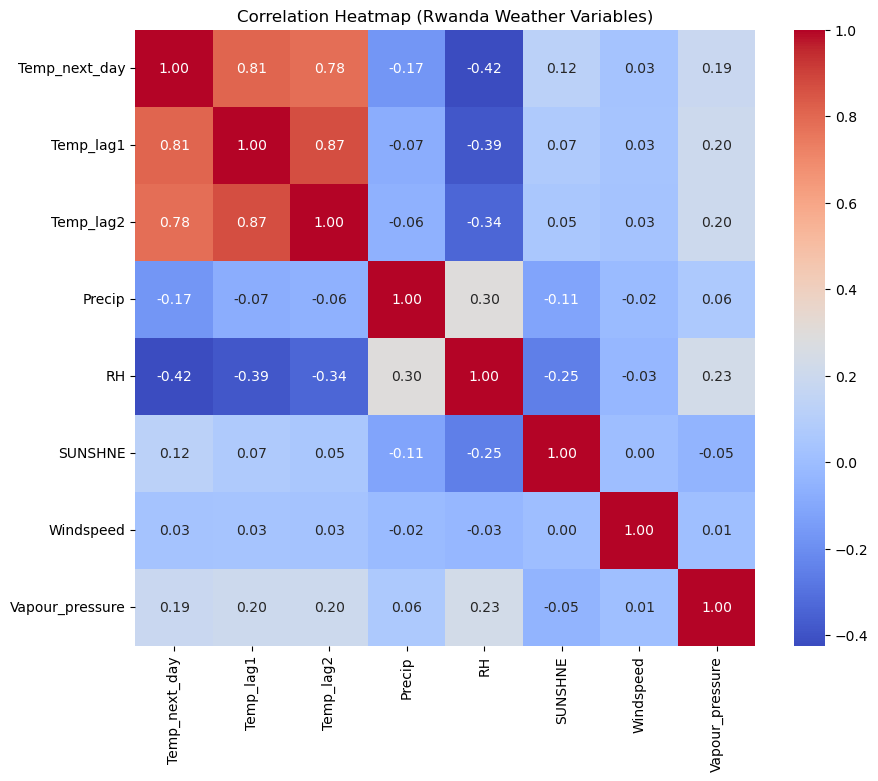

In [100]:
# 4.1 Correlation heatmap (core predictors)
corr_cols = ["Temp_next_day"] + available_predictors
plt.figure(figsize=(10,8))
sns.heatmap(cleaned_df[corr_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Rwanda Weather Variables)")
plt.show()


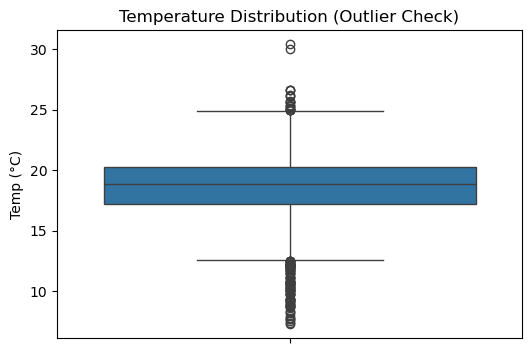

In [101]:
# 4.2 Temperature distribution boxplot
plt.figure(figsize=(6,4))
sns.boxplot(y=cleaned_df["Temp"])
plt.title("Temperature Distribution (Outlier Check)")
plt.ylabel("Temp (°C)")
plt.show()


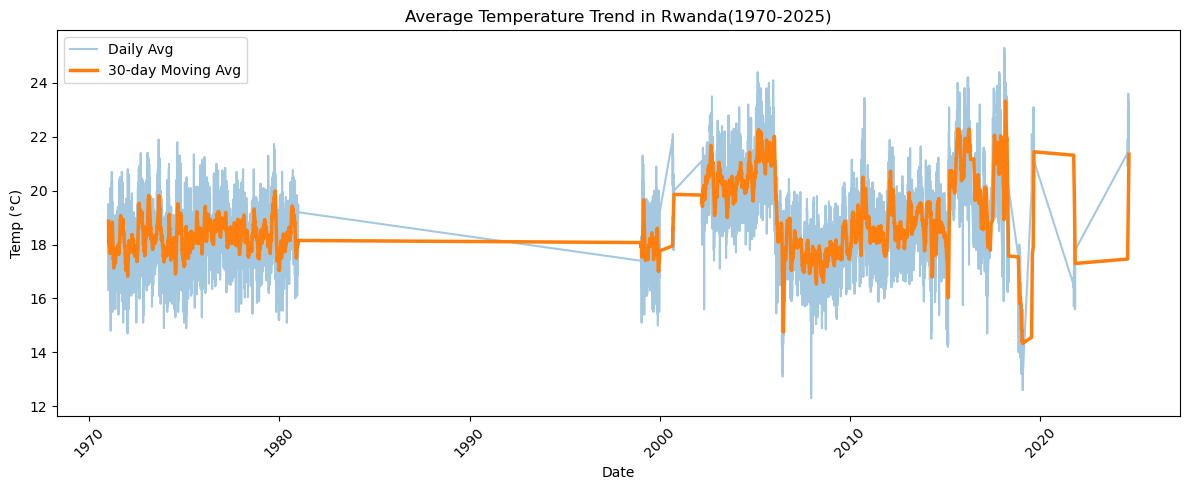

In [111]:
# 4.3 Smoothed average temperature trend (daily average + 30-day moving average)
daily_avg = cleaned_df.groupby("date")["Temp"].mean().reset_index()
daily_avg["Temp_smooth_30d"] = daily_avg["Temp"].rolling(window=30, min_periods=10).mean()

plt.figure(figsize=(12,5))
plt.plot(daily_avg["date"], daily_avg["Temp"], alpha=0.4, label="Daily Avg")
plt.plot(daily_avg["date"], daily_avg["Temp_smooth_30d"], linewidth=2.5, label="30-day Moving Avg")
plt.title("Average Temperature Trend in Rwanda(1970-2025)")
plt.xlabel("Date"); plt.ylabel("Temp (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


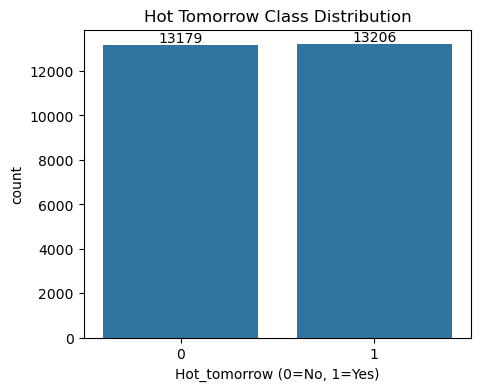

In [112]:
# 4.4 Hot tomorrow class distribution
plt.figure(figsize=(5,4))

ax = sns.countplot(x=cleaned_df["Hot_tomorrow"])

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title("Hot Tomorrow Class Distribution")
plt.xlabel("Hot_tomorrow (0=No, 1=Yes)")
plt.show()


## 5. Train/Test Split (per station)
This avoids leakage by ensuring each station is split chronologically.

In [104]:
def time_split_per_station(data, station_col="StationId", date_col="date", test_frac=0.2):
    train_parts, test_parts = [], []
    for sid, g in data.groupby(station_col):
        g = g.sort_values(date_col)
        n = len(g)
        cut = int(np.floor((1 - test_frac) * n))
        train_parts.append(g.iloc[:cut])
        test_parts.append(g.iloc[cut:])
    return pd.concat(train_parts).reset_index(drop=True), pd.concat(test_parts).reset_index(drop=True)

train_df, test_df = time_split_per_station(cleaned_df, test_frac=0.2)
print("Train size:", train_df.shape, "Test size:", test_df.shape)


Train size: (21105, 20) Test size: (5280, 20)


## 6. Modeling  Section 

In [105]:
# X/y ( X_train , y_train , X_test and y_test)
X_train = train_df[available_predictors]
y_train = train_df["Temp_next_day"]
X_test  = test_df[available_predictors]
y_test  = test_df["Temp_next_day"]


def eval_reg(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


### 6.1 Model 1: Linear Regression

In [106]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred_lr = lr_reg.predict(X_test)

mae_lr, rmse_lr, r2_lr = eval_reg(y_test, pred_lr)
(mae_lr, rmse_lr, r2_lr)


(0.9529547577700601, np.float64(1.2507191457231321), 0.7162164136009066)

### 6.2 Model 2: Random Forest Regressor

In [107]:
rf_reg = RandomForestRegressor(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_reg.fit(X_train, y_train)
pred_rf = rf_reg.predict(X_test)

mae_rf, rmse_rf, r2_rf = eval_reg(y_test, pred_rf)
(mae_rf, rmse_rf, r2_rf)


(0.940654189789762, np.float64(1.258783710121045), 0.7125449748668404)

### 6.3 Model 3 (Deep Learning): MLP Regressor

In [108]:
mlp_reg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(64,32),
                        random_state=RANDOM_STATE,
                        max_iter=500))
])
mlp_reg.fit(X_train, y_train)
pred_mlp = mlp_reg.predict(X_test)

mae_mlp, rmse_mlp, r2_mlp = eval_reg(y_test, pred_mlp)
(mae_mlp, rmse_mlp, r2_mlp)


(0.9119249094341544, np.float64(1.2055168347575056), 0.7363582194095972)

### 6.4 Regression comparison table

In [109]:
reg_results = pd.DataFrame([
    {"Task":"Regression", "Model":"Linear Regression", "MAE":mae_lr, "RMSE":rmse_lr, "R2":r2_lr},
    {"Task":"Regression", "Model":"Random Forest Regressor", "MAE":mae_rf, "RMSE":rmse_rf, "R2":r2_rf},
    {"Task":"Regression", "Model":"MLP Regressor", "MAE":mae_mlp, "RMSE":rmse_mlp, "R2":r2_mlp},
]).sort_values("RMSE")

reg_results


,Task,Model,MAE,RMSE,R2
2,Regression,MLP Regressor,0.911925,1.205517,0.736358
0,Regression,Linear Regression,0.952955,1.250719,0.716216
1,Regression,Random Forest Regressor,0.940654,1.258784,0.712545


## 7. Model Improvement ( apply Parameter Tuning) on Random Forest ( Regression focus)

In [110]:
param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

rf_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_
search.best_params_


{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 50}

In [113]:
# Evaluate tuned model
pred_best = best_rf.predict(X_test)
mae_best, rmse_best, r2_best = eval_reg(y_test, pred_best)
(mae_best, rmse_best, r2_best)


(0.9110837975844209, np.float64(1.2183584649200372), 0.7307114752912953)

In [114]:
# Before vs after tuning
improve_table = pd.DataFrame([
    {"Model":"Random Forest (Before)", "MAE":mae_rf, "RMSE":rmse_rf, "R2":r2_rf},
    {"Model":"Random Forest (After)",  "MAE":mae_best, "RMSE":rmse_best, "R2":r2_best},
])
improve_table


,Model,MAE,RMSE,R2
0,Random Forest (Before),0.940654,1.258784,0.712545
1,Random Forest (After),0.911084,1.218358,0.730711


## 8. Cross-Validation Summary (TimeSeriesSplit) — specifically for Weather

In [115]:
tscv = TimeSeriesSplit(n_splits=5)

# Use the tuned model 
model_for_cv = best_rf if 'best_rf' in globals() else rf_reg

ts_rmse = -cross_val_score(
    model_for_cv,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=tscv
)

print("TimeSeriesSplit RMSE per fold:", ts_rmse)
print("Mean RMSE:", ts_rmse.mean())
print("Std RMSE:", ts_rmse.std())


TimeSeriesSplit RMSE per fold: [1.41959375 1.15162669 1.38696516 1.08563347 1.2547065 ]
Mean RMSE: 1.2597051111570188
Std RMSE: 0.1294344347007679


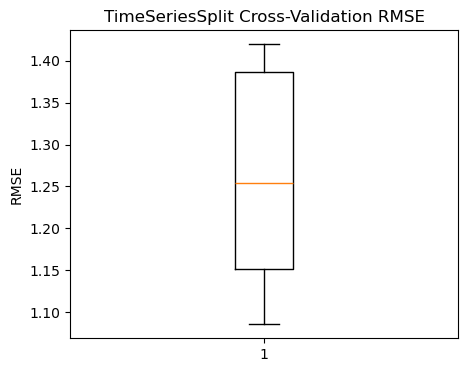

In [116]:
# CV RMSE boxplot
plt.figure(figsize=(5,4))
plt.boxplot(ts_rmse)
plt.title("TimeSeriesSplit Cross-Validation RMSE")
plt.ylabel("RMSE")
plt.show()

## 9. Feature Importance

In [119]:
# Feature importance from Random Forest (best_rf or rf_reg)
rf_for_fi = best_rf if 'best_rf' in globals() else rf_reg

fi = pd.DataFrame({
    "Feature": available_predictors,
    "Importance": rf_for_fi.feature_importances_
}).sort_values("Importance", ascending=False)

fi


,Feature,Importance
0,Temp_lag1,0.398154
1,Temp_lag2,0.313878
3,RH,0.108822
6,Vapour_pressure,0.095883
2,Precip,0.040983
4,SUNSHNE,0.039674
5,Windspeed,0.002606


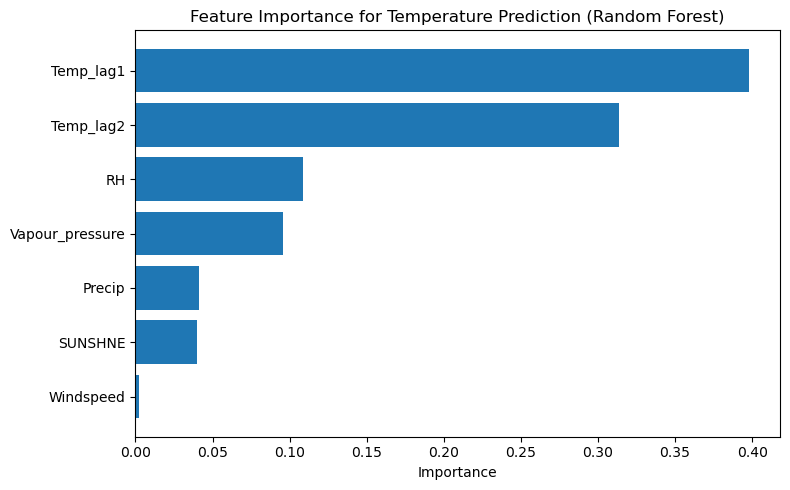

In [120]:
plt.figure(figsize=(8,5))
plt.barh(fi["Feature"], fi["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance for Temperature Prediction (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 10.classification

In [122]:
Xc_train = train_df[available_predictors]
yc_train = train_df["Hot_tomorrow"]
Xc_test  = test_df[available_predictors]
yc_test  = test_df["Hot_tomorrow"]

def eval_clf(y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_prob)
    }

log_clf = Pipeline(steps=[("scaler", StandardScaler()),
                         ("log", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
log_clf.fit(Xc_train, yc_train)
prob_log = log_clf.predict_proba(Xc_test)[:,1]
res_log = eval_clf(yc_test, prob_log)

rf_clf = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
rf_clf.fit(Xc_train, yc_train)
prob_rf_clf = rf_clf.predict_proba(Xc_test)[:,1]
res_rf = eval_clf(yc_test, prob_rf_clf)

mlp_clf = Pipeline(steps=[("scaler", StandardScaler()),
                         ("mlp", MLPClassifier(hidden_layer_sizes=(64,32),
                                               max_iter=500,
                                               random_state=RANDOM_STATE))])
mlp_clf.fit(Xc_train, yc_train)
prob_mlp = mlp_clf.predict_proba(Xc_test)[:,1]
res_mlp = eval_clf(yc_test, prob_mlp)

clf_results = pd.DataFrame([
    {"Task":"Classification", "Model":"Logistic Regression", **res_log},
    {"Task":"Classification", "Model":"Random Forest", **res_rf},
    {"Task":"Classification", "Model":"MLP Classifier", **res_mlp},
]).sort_values("F1", ascending=False)

clf_results


,Task,Model,Accuracy,F1,ROC_AUC
1,Classification,Random Forest,0.848864,0.866911,0.920614
2,Classification,MLP Classifier,0.845833,0.864198,0.921607
0,Classification,Logistic Regression,0.832386,0.849464,0.916512


Best K: 3 Silhouette: 0.25594969797629846


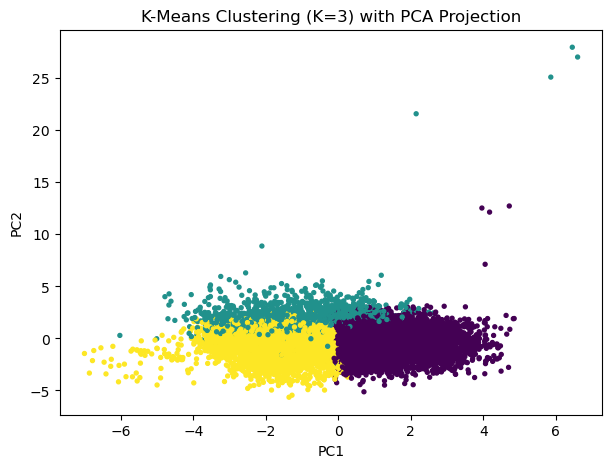

In [126]:
#  Clustering
X_cluster = cleaned_df[available_predictors].copy()

# Scale for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Choose K by silhouette 
scores = {}
for k in range(3, 10):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    scores[k] = silhouette_score(X_scaled, labels)

best_k = max(scores, key=scores.get)
print("Best K:", best_k, "Silhouette:", scores[best_k])

km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
labels = km.fit_predict(X_scaled)

# PCA visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
xy = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(xy[:,0], xy[:,1], c=labels, s=8)
plt.title(f"K-Means Clustering (K={best_k}) with PCA Projection")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


### Clustering Interpretation
K-Means clustering with K=3 grouped the Rwanda weather data into three main patterns. The PCA plot shows that the clusters are mostly separated along the first principal component, meaning that the main variation in the weather data has been captured well. The silhouette score of 0.2556 indicates moderate but meaningful clustering, which is reasonable for weather data because atmospheric conditions change gradually. Overall, the three clusters likely represent dry, normal, and wet weather conditions in Rwanda

## 11. Final Conclusion

In [127]:
# Summary about the b
best_reg = reg_results.iloc[0]
print("Best regression model (by RMSE):", best_reg["Model"])
print("RMSE:", best_reg["RMSE"], "MAE:", best_reg["MAE"], "R2:", best_reg["R2"])

print("\nTuning impact (RF before vs after):")
display(improve_table)

print("\nTimeSeriesSplit CV RMSE mean/std:")
print(ts_rmse.mean(), ts_rmse.std())

print("\nTop predictors by importance:")
display(fi.head(5))


Best regression model (by RMSE): MLP Regressor
RMSE: 1.2055168347575056 MAE: 0.9119249094341544 R2: 0.7363582194095972

Tuning impact (RF before vs after):


,Model,MAE,RMSE,R2
0,Random Forest (Before),0.940654,1.258784,0.712545
1,Random Forest (After),0.911084,1.218358,0.730711



TimeSeriesSplit CV RMSE mean/std:
1.2597051111570188 0.1294344347007679

Top predictors by importance:


,Feature,Importance
0,Temp_lag1,0.398154
1,Temp_lag2,0.313878
3,RH,0.108822
6,Vapour_pressure,0.095883
2,Precip,0.040983
